In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats

In [72]:
def find_index(geo_df, bh, depth):
    try: 
        filtered_df = geo_df[geo_df["PointID"] == bh]
        bottom_depth = filtered_df["Depth"].iloc[-1]
        for index, row in filtered_df.iterrows():
            if depth >= row["Top depth"] and depth < row["Depth"]:
                ind = row["Index"]
            elif depth == bottom_depth:
                ind =  bottom_depth = filtered_df["Index"].iloc[-1]
                break
        return ind
    except Exception as e:
        print("find_index", bh, depth, e)
        return "error"

## Import Su from raw gINT data

In [75]:
geo_df

Unnamed: 0        PointID  Top depth  Depth  Index Mean BD (kn/m3)  \
0             0  544WTG23-BH01       0.00   2.80      1           19.11   
1             1  544WTG23-BH01       2.80   7.90      2          18.326   
2             2  544WTG23-BH01       7.90  10.60      3         19.7715   
3             3  544WTG23-BH01      10.60  12.55      4         19.6392   
4             4  544WTG23-BH01      12.55  16.00      5          18.816   
..          ...            ...        ...    ...    ...             ...   
119         119  544WTG23-BH11      17.00  27.60      6          18.228   
120         120  544WTG23-BH11      27.60  29.00      7          18.767   
121         121  544WTG23-BH11      29.00  30.50      8          19.306   
122         122  544WTG23-BH11      30.50  36.50      9          17.346   
123         123  544WTG23-BH11      36.50  50.20     10          17.444   

     Cum BD (kn/m3)  
0          0.000000  
1         53.508000  
2        198.283400  
3        407.861300  
4        654.333260  
..              ...  
119      970.125247  
120     1473.218047  
121     2017.461047  
122     2606.294047  
123     3239.423047  

[124 rows x 7 columns]

In [77]:
sample, depth, su, test = [], [], [], []
su_dict = {
    "LPEN" : "LPEN_PPEN",
    "TORV":"TORV_PUSS",
    "UU":"TRIT_CU",
    "CU":"TRET_SHST",
    "DSS":"DSST_FSHS"}

for test_type in su_dict:
    df = pd.read_excel("data/gint export_310724_su.xlsx", test_type)
    if test_type == "CU":
        cu_test_type = df["Test type"].to_list()
    # Add id, su and tests into respective lists
    for i in range(len(df)):
        sample.append(df["PointID"][i][:13])
        depth.append(df["Depth"][i])
        su.append(abs(df[su_dict[test_type]][i]))    # use abs here because some Su from CAUe are negative
        if test_type == "CU":
            test.append(df["Test type"][i])
        else:
            test.append(test_type)


su_df = pd.DataFrame(list(zip(sample, depth, su, test)), columns=["PointID", "Depth", "Su", "Test"])
su_df["Index"] = su_df.apply(lambda x: find_index(geo_df, x.PointID, x.Depth), axis=1)

In [8]:
cpt_df = pd.read_excel("data/CPT parameter.xlsx")
geo_df = pd.read_excel("data/BD profile.xlsx")
geo_df

Unnamed: 0        PointID  Top depth  Depth  Index Mean BD (kn/m3)  \
0             0  544WTG23-BH01       0.00   2.80      1           19.11   
1             1  544WTG23-BH01       2.80   7.90      2          18.326   
2             2  544WTG23-BH01       7.90  10.60      3         19.7715   
3             3  544WTG23-BH01      10.60  12.55      4         19.6392   
4             4  544WTG23-BH01      12.55  16.00      5          18.816   
..          ...            ...        ...    ...    ...             ...   
119         119  544WTG23-BH11      17.00  27.60      6          18.228   
120         120  544WTG23-BH11      27.60  29.00      7          18.767   
121         121  544WTG23-BH11      29.00  30.50      8          19.306   
122         122  544WTG23-BH11      30.50  36.50      9          17.346   
123         123  544WTG23-BH11      36.50  50.20     10          17.444   

     Cum BD (kn/m3)  
0          0.000000  
1         53.508000  
2        198.283400  
3        407.861300  
4        654.333260  
..              ...  
119      970.125247  
120     1473.218047  
121     2017.461047  
122     2606.294047  
123     3239.423047  

[124 rows x 7 columns]

# Calculate Su for different Nkt values

In [78]:
cpt_df["Su (Nkt 10)"] = (cpt_df["qnet (kPa)"] - cpt_df["σv (kPa)"]) / 10
cpt_df["Su (Nkt 20)"] =  (cpt_df["qnet (kPa)"] - cpt_df["σv (kPa)"]) / 20
cpt_df

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0        PointID CPT_hole  \
0                 0             0           0  544WTG23-BH10    CPT10   
1                 1             1           1  544WTG23-BH10    CPT10   
2                 2             2           2  544WTG23-BH10    CPT10   
3                 3             3           3  544WTG23-BH10    CPT10   
4                 4             4           4  544WTG23-BH10    CPT10   
...             ...           ...         ...            ...      ...   
39348         39348         46587       46587  544WTG23-BH11    CPT11   
39349         39349         46588       46588  544WTG23-BH11    CPT11   
39350         39350         46589       46589  544WTG23-BH11    CPT11   
39351         39351         46590       46590  544WTG23-BH11    CPT11   
39352         39352         46591       46591  544WTG23-BH11    CPT11   

       Depth (m)   qc (MPa)  fs (MPa)   Inc. NS    Inc EW  ...        Bq   Ic  \
0        0.00000   0.003214       0.0 -0.425142  0.372760  ...  1.006624  0.0   
1        0.01000   0.003214       0.0 -1.389042 -0.696828  ...  1.006405  0.0   
2        0.02000   0.003214       0.0 -0.095290  0.021505  ...  1.006186  0.0   
3        0.03000   0.003214       0.0 -0.197911  0.881720  ...  1.005968  0.0   
4        0.04000   0.003214       0.0 -0.535092  0.777778  ...  1.005750  0.0   
...          ...        ...       ...       ...       ...  ...       ...  ...   
39348   14.61024  45.343010       0.0  0.163881 -2.779262  ... -0.171087  0.0   
39349   14.62024  45.557530       0.0  0.175762 -3.620167  ... -0.045819  0.0   
39350   14.63024  51.760460       0.0  0.229843 -3.841083  ... -0.066450  0.0   
39351   14.64024  37.670360       0.0  0.188463 -3.734188  ... -0.056711  0.0   
39352   14.65024  43.631380       0.0  0.198705 -5.961162  ... -0.092143  0.0   

                Su  OCR Robertson  OCR Mayne      Su/σ'v  Qnc  mCPTu  \
0       -29.511864            0.0        0.0        -inf  0.0    0.0   
1       -29.525234            0.0        0.0 -331.074618  0.0    0.0   
2       -29.538604            0.0        0.0 -165.612270  0.0    0.0   
3       -29.551974            0.0        0.0 -110.458154  0.0    0.0   
4       -29.565344            0.0        0.0  -82.881096  0.0    0.0   
...            ...            ...        ...         ...  ...    ...   
39348  3079.435837            0.0        0.0    9.998814  0.0    0.0   
39349  3171.057606            0.0        0.0   10.293190  0.0    0.0   
39350  3595.388360            0.0        0.0   11.667028  0.0    0.0   
39351  2607.152243            0.0        0.0    8.457645  0.0    0.0   
39352  3007.081212            0.0        0.0    9.752071  0.0    0.0   

       Su (Nkt 10)  Su (Nkt 20)  
0       -41.316610   -20.658305  
1       -41.335328   -20.667664  
2       -41.354046   -20.677023  
3       -41.372764   -20.686382  
4       -41.391482   -20.695741  
...            ...          ...  
39348  4311.210172  2155.605086  
39349  4439.480648  2219.740324  
39350  5033.543704  2516.771852  
39351  3650.013140  1825.006570  
39352  4209.913696  2104.956848  

[39353 rows x 28 columns]

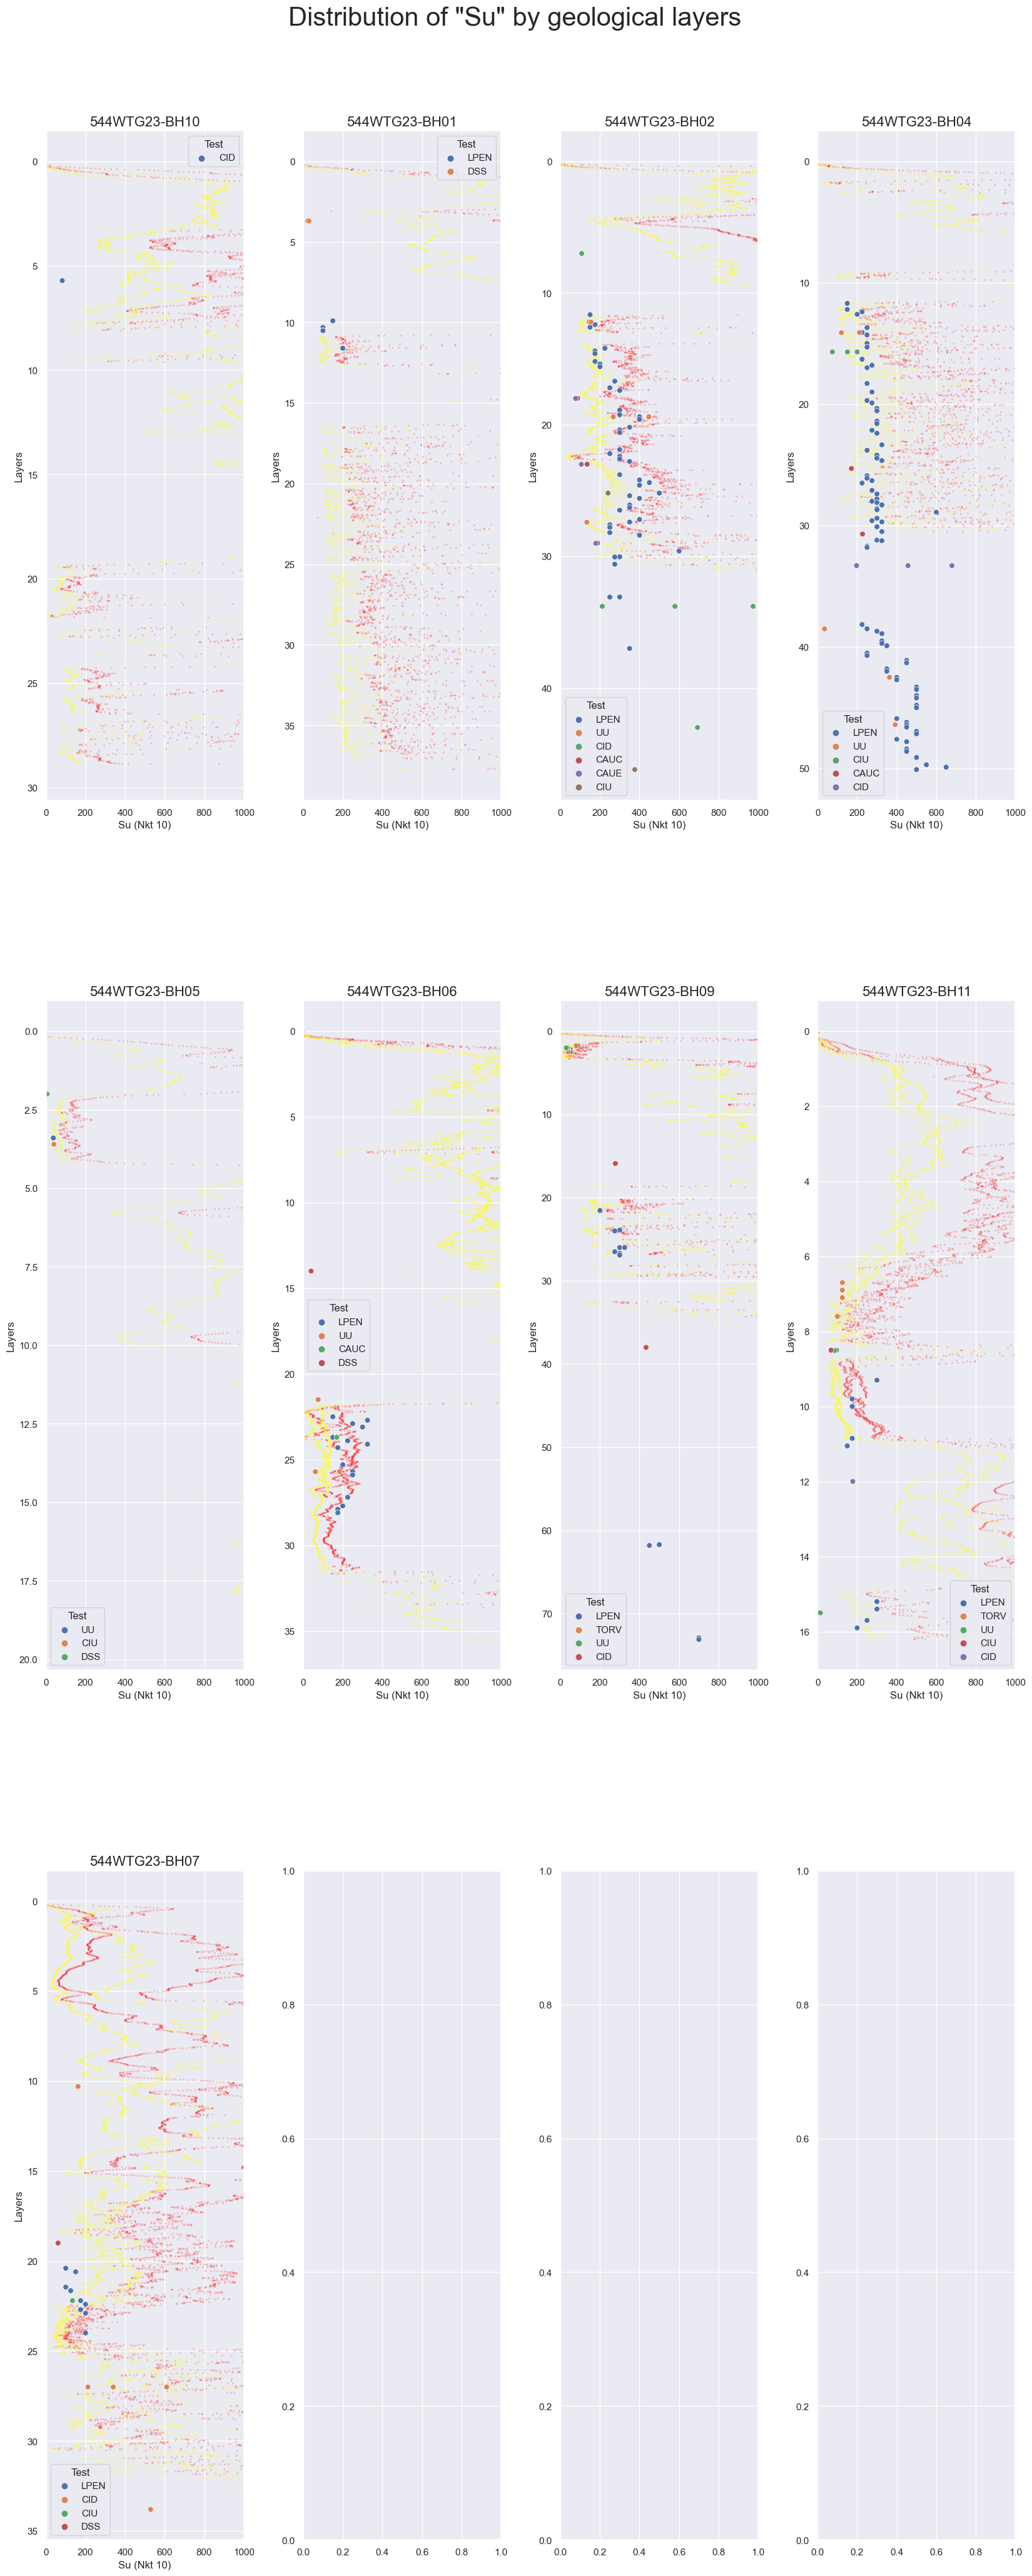

In [28]:
plot_df = cpt_df
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(3, 4)
fig.suptitle(f'Distribution of "Su" by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 50)})
sns.set(font_scale=1) 
for row in range(3):
    for col in range(4):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 10)", y="Depth (m)", alpha=0.2, ax=axes[row, col], s=5, color="red")
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 20)", y="Depth (m)", alpha=0.2, ax=axes[row, col], s=5, color="yellow")
            ax = sns.scatterplot(data=fsu_df, x="Su", y="Depth", hue="Test", alpha=1, ax=axes[row, col], s=40)
            ax.set_title(borehole_list[bh], size=16)
            ax.set_ylabel("Layers")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            bh += 1

## Derive Nkt

In [79]:
def find_Nkt(cpt_df, bh, depth, cpt_su):
    df = cpt_df[cpt_df["PointID"] == bh]
    df = df[(df["Depth (m)"] < depth + 0.1) & (df["Depth (m)"] > depth - 0.1)]
    Nkt = (df["qnet (kPa)"].mean() - df["σv (kPa)"].mean()) / cpt_su
    return Nkt, df["qnet (kPa)"].mean() - df["σv (kPa)"].mean()

def find_Nkt_layer(cpt_df, bh, depth, index, cpt_su):
    df = cpt_df[(cpt_df["PointID"] == bh) & (cpt_df["Index"] == index)]
    Nkt = (df["qnet (kPa)"].mean() - df["σv (kPa)"].mean()) / cpt_su
    return Nkt, df["qnet (kPa)"].mean() - df["σv (kPa)"].mean()

In [80]:
su_df[["Derived Nkt", "qnet - σv"]] = su_df.apply(lambda x: find_Nkt_layer(cpt_df, x.PointID, x.Depth, x.Index, x.Su),
                                                  axis=1, result_type="expand")

su_df[["Derived Nkt", "qnet - σv"]] = su_df.apply(lambda x: find_Nkt(cpt_df, x.PointID, x.Depth, x.Su), axis=1, result_type="expand")
# su_df["Nkt check"] = su_df["Derived Nkt"].apply(lambda x: "In" if (x <= 20 and x > 10) else ("Mid" if (x < 25 and x > 10) else "Out"))
su_df["Nkt check"] = su_df["Derived Nkt"].apply(lambda x: "In" if (x <= 20 and x > 10) else "Out")
su_df

nan nan


(0.0, 400.0)

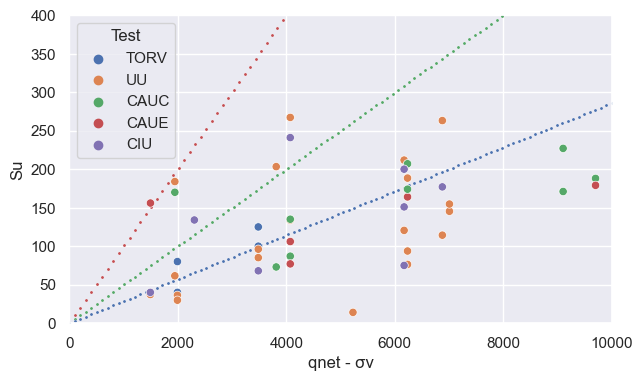

In [81]:
plot_df = su_df[(su_df["Test"] != "LPEN") & (su_df["Test"] != "CID") & (su_df["Test"] != "DSS")]

linex = np.linspace(0, 10000, 100)
liney10 = (1/10)*linex
liney20 = (1/20)*linex
liney30 = (1/35)*linex
ax = sns.set(rc={"figure.figsize":(7, 4)})
ax = sns.scatterplot(x=linex, y=liney10, s=5, color="r")
ax = sns.scatterplot(x=linex, y=liney20, s=5, color="g")
ax = sns.scatterplot(x=linex, y=liney30, s=5, color="b")
#ax = sns.regplot(x=plot_df["qnet - σv"], y=plot_df["Su"], color="pink")
ax = sns.scatterplot(data=plot_df, x="qnet - σv", y="Su", hue="Test")
# get equation of line
slope, intercept, r, p, sterr = scipy.stats.linregress(x=plot_df["qnet - σv"], y=plot_df["Su"])
print(round(slope, 2), round(intercept, 2))
ax.set_xlim(0, 10000)
ax.set_ylim(0, 400)

nan nan


(0.0, 400.0)

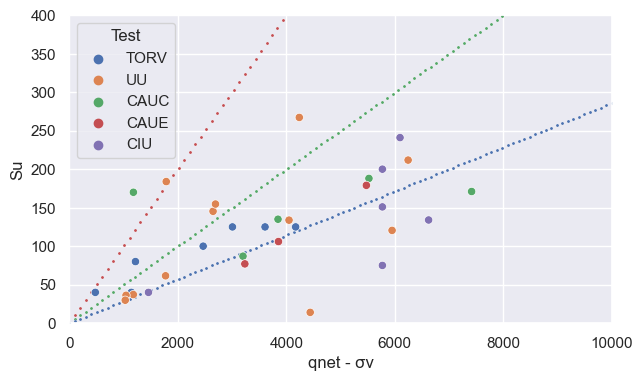

In [66]:
plot_df = su_df[(su_df["Test"] != "LPEN") & (su_df["Test"] != "CID") & (su_df["Test"] != "DSS")]

linex = np.linspace(0, 10000, 100)
liney10 = (1/10)*linex
liney20 = (1/20)*linex
liney30 = (1/35)*linex
ax = sns.set(rc={"figure.figsize":(7, 4)})
ax = sns.scatterplot(x=linex, y=liney10, s=5, color="r")
ax = sns.scatterplot(x=linex, y=liney20, s=5, color="g")
ax = sns.scatterplot(x=linex, y=liney30, s=5, color="b")
#ax = sns.regplot(x=plot_df["qnet - σv"], y=plot_df["Su"], color="pink")
ax = sns.scatterplot(data=plot_df, x="qnet - σv", y="Su", hue="Test")
# get equation of line
slope, intercept, r, p, sterr = scipy.stats.linregress(x=plot_df["qnet - σv"], y=plot_df["Su"])
print(round(slope, 2), round(intercept, 2))
ax.set_xlim(0, 10000)
ax.set_ylim(0, 400)

(0.0, 100.0)

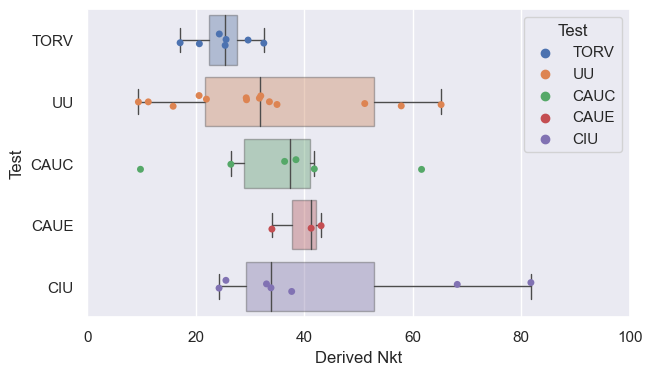

In [60]:
#plot_df = su_df[su_df["Nkt check"] == "In"]
#plot_df = su_df
sns.set(rc={"figure.figsize":(7, 4)})
sns.boxplot(data=plot_df, x="Derived Nkt", y="Test", boxprops=dict(alpha=.4), linewidth=1, showfliers= False)
sns.stripplot(data=plot_df, x="Derived Nkt", y="Test", orient="h", hue="Test").set_xlim(0, 100)

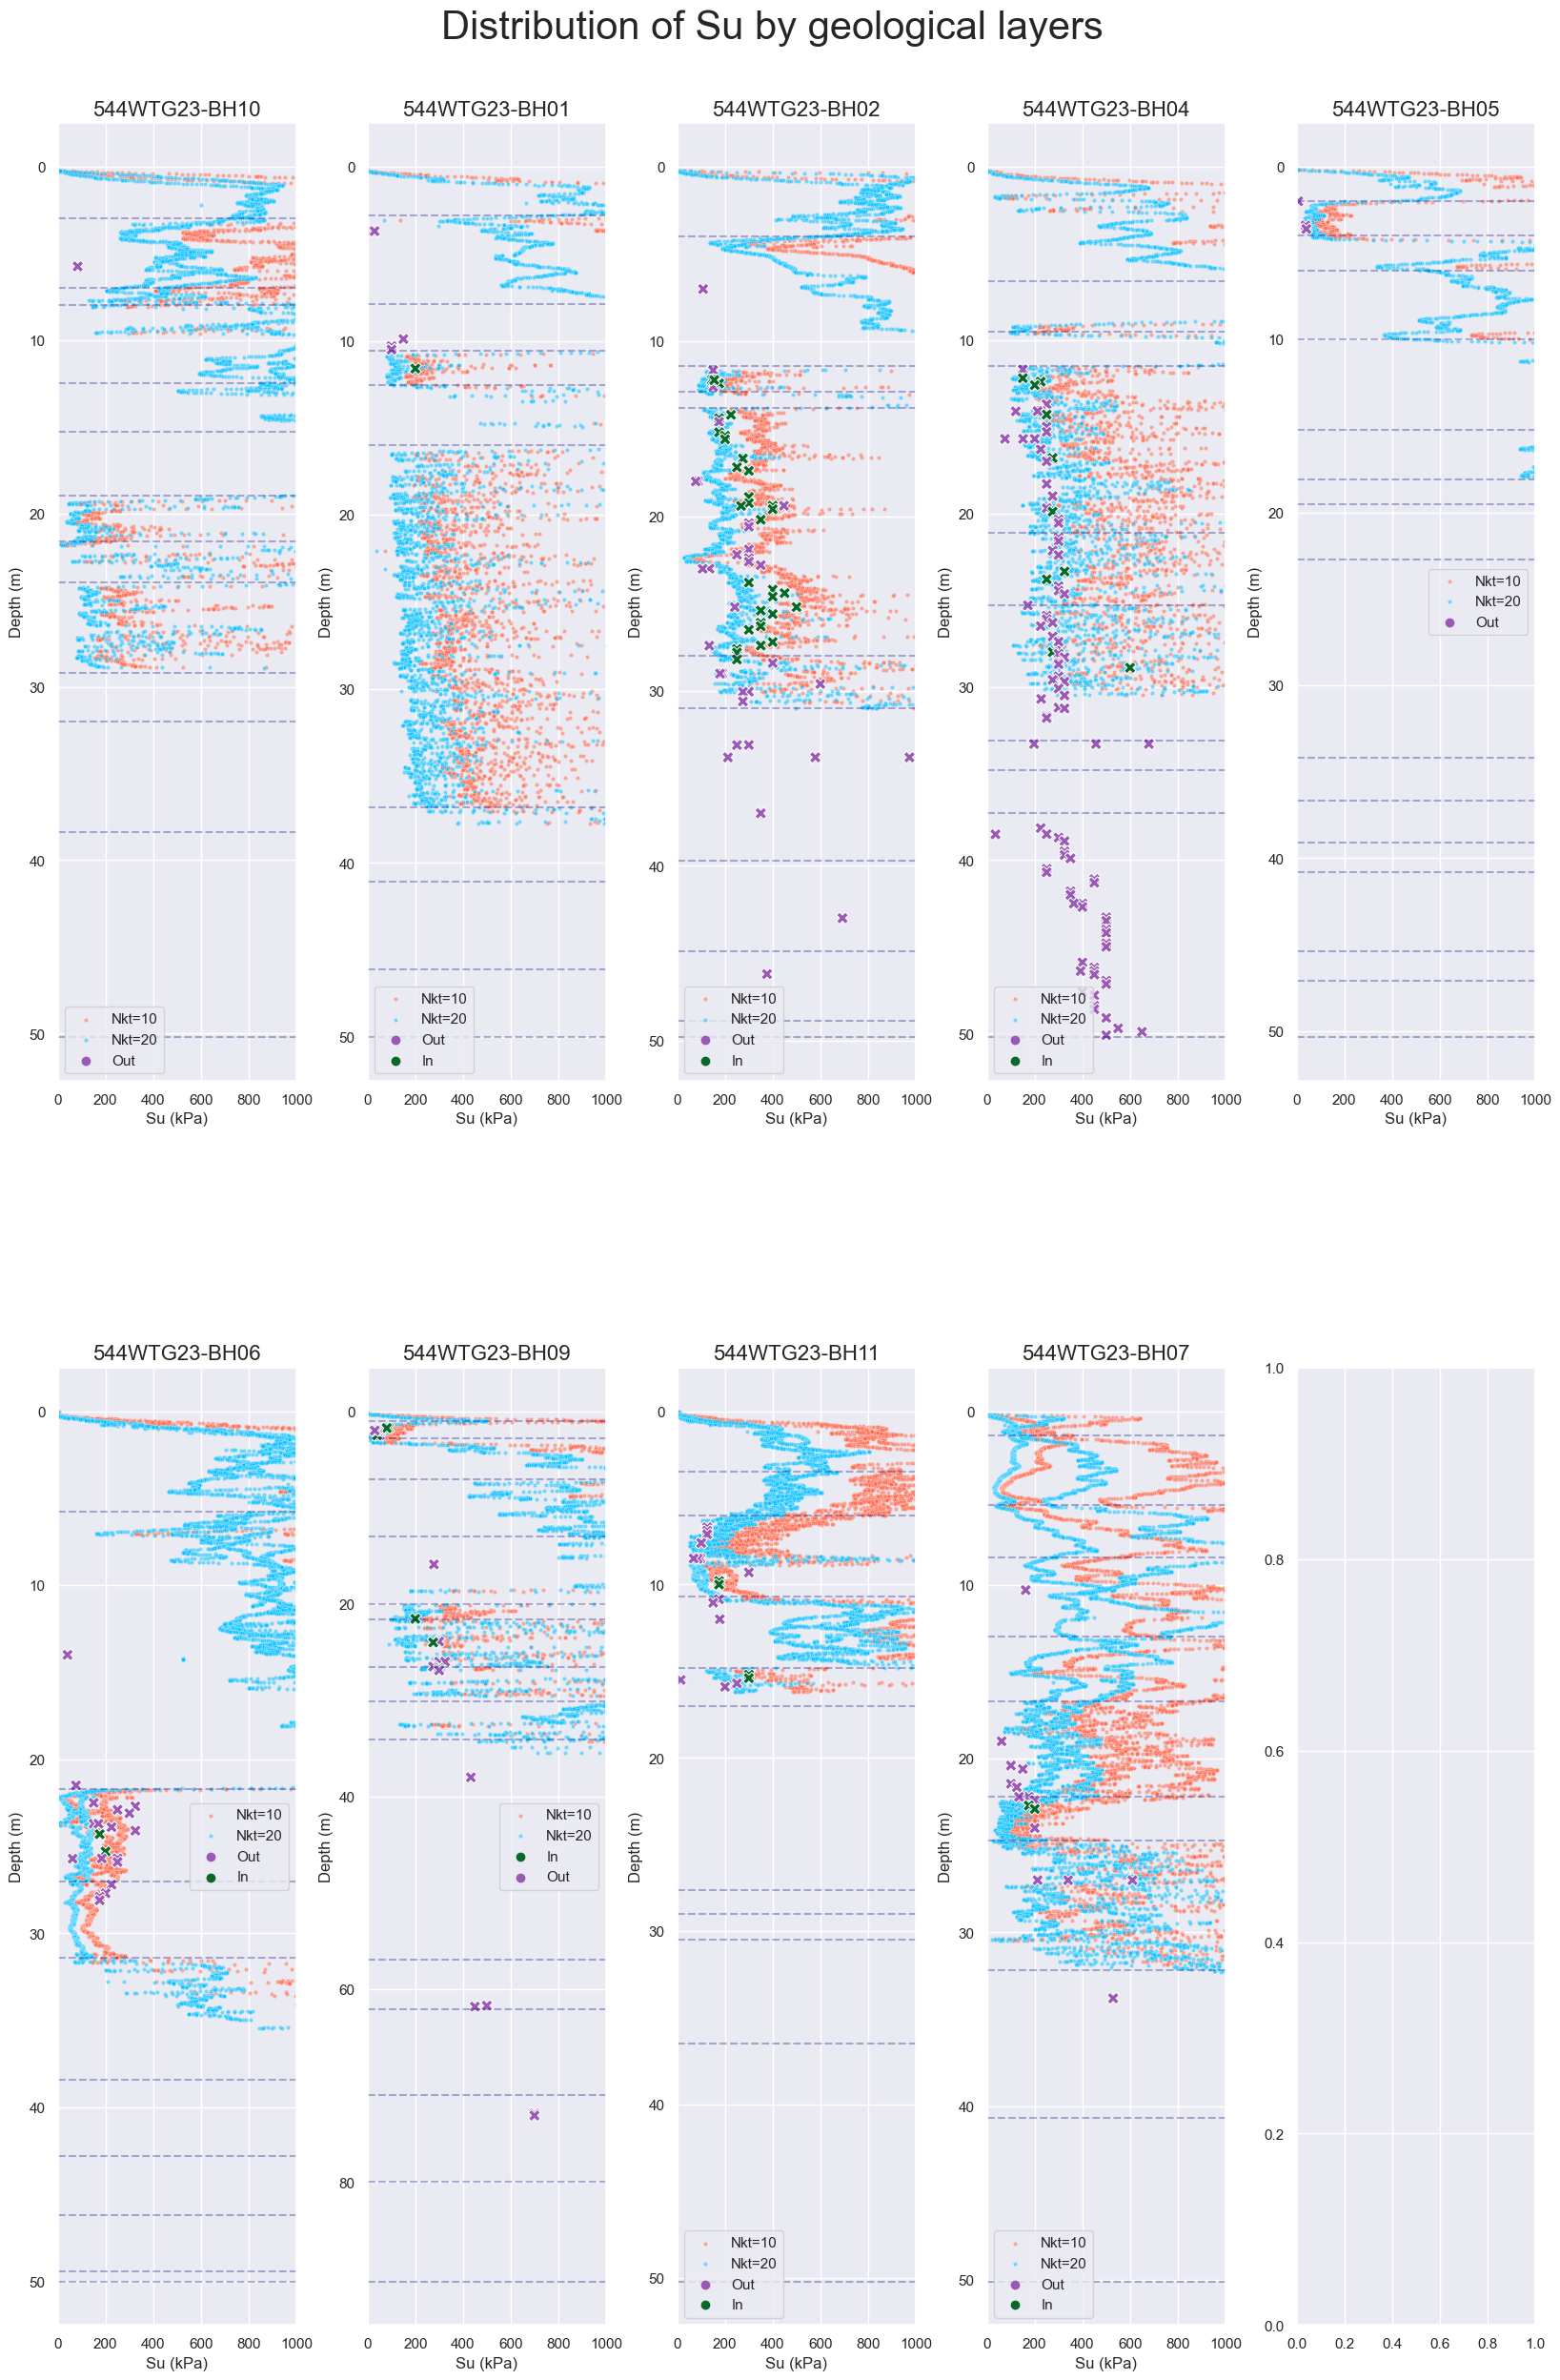

In [22]:
plot_df = cpt_df
xmin, xmax = 0, 1000
############################
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(2, 5)
fig.suptitle(f'Distribution of {parameter} by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 30)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 10)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="tomato", s=10, label="Nkt=10")
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 20)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="deepskyblue", s=10, label="Nkt=20")
            ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Nkt check", marker="X", alpha=1, ax=axes[row, col], s=80,
                                palette=dict(Out="#9b59b6", In="#076928", Mid="#f20000"))
            # Plot geology
            bh_geo = geo_df[geo_df["PointID"] == borehole_list[bh]]
            for z in bh_geo["Depth"].to_list():
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=0.3, color="navy", linestyle='dashed')
            ax.set_title(borehole_list[bh], size=16)
            ax.set_ylabel("Depth (m)")
            ax.set_xlabel("Su (kPa)")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            ax.legend()
            bh += 1

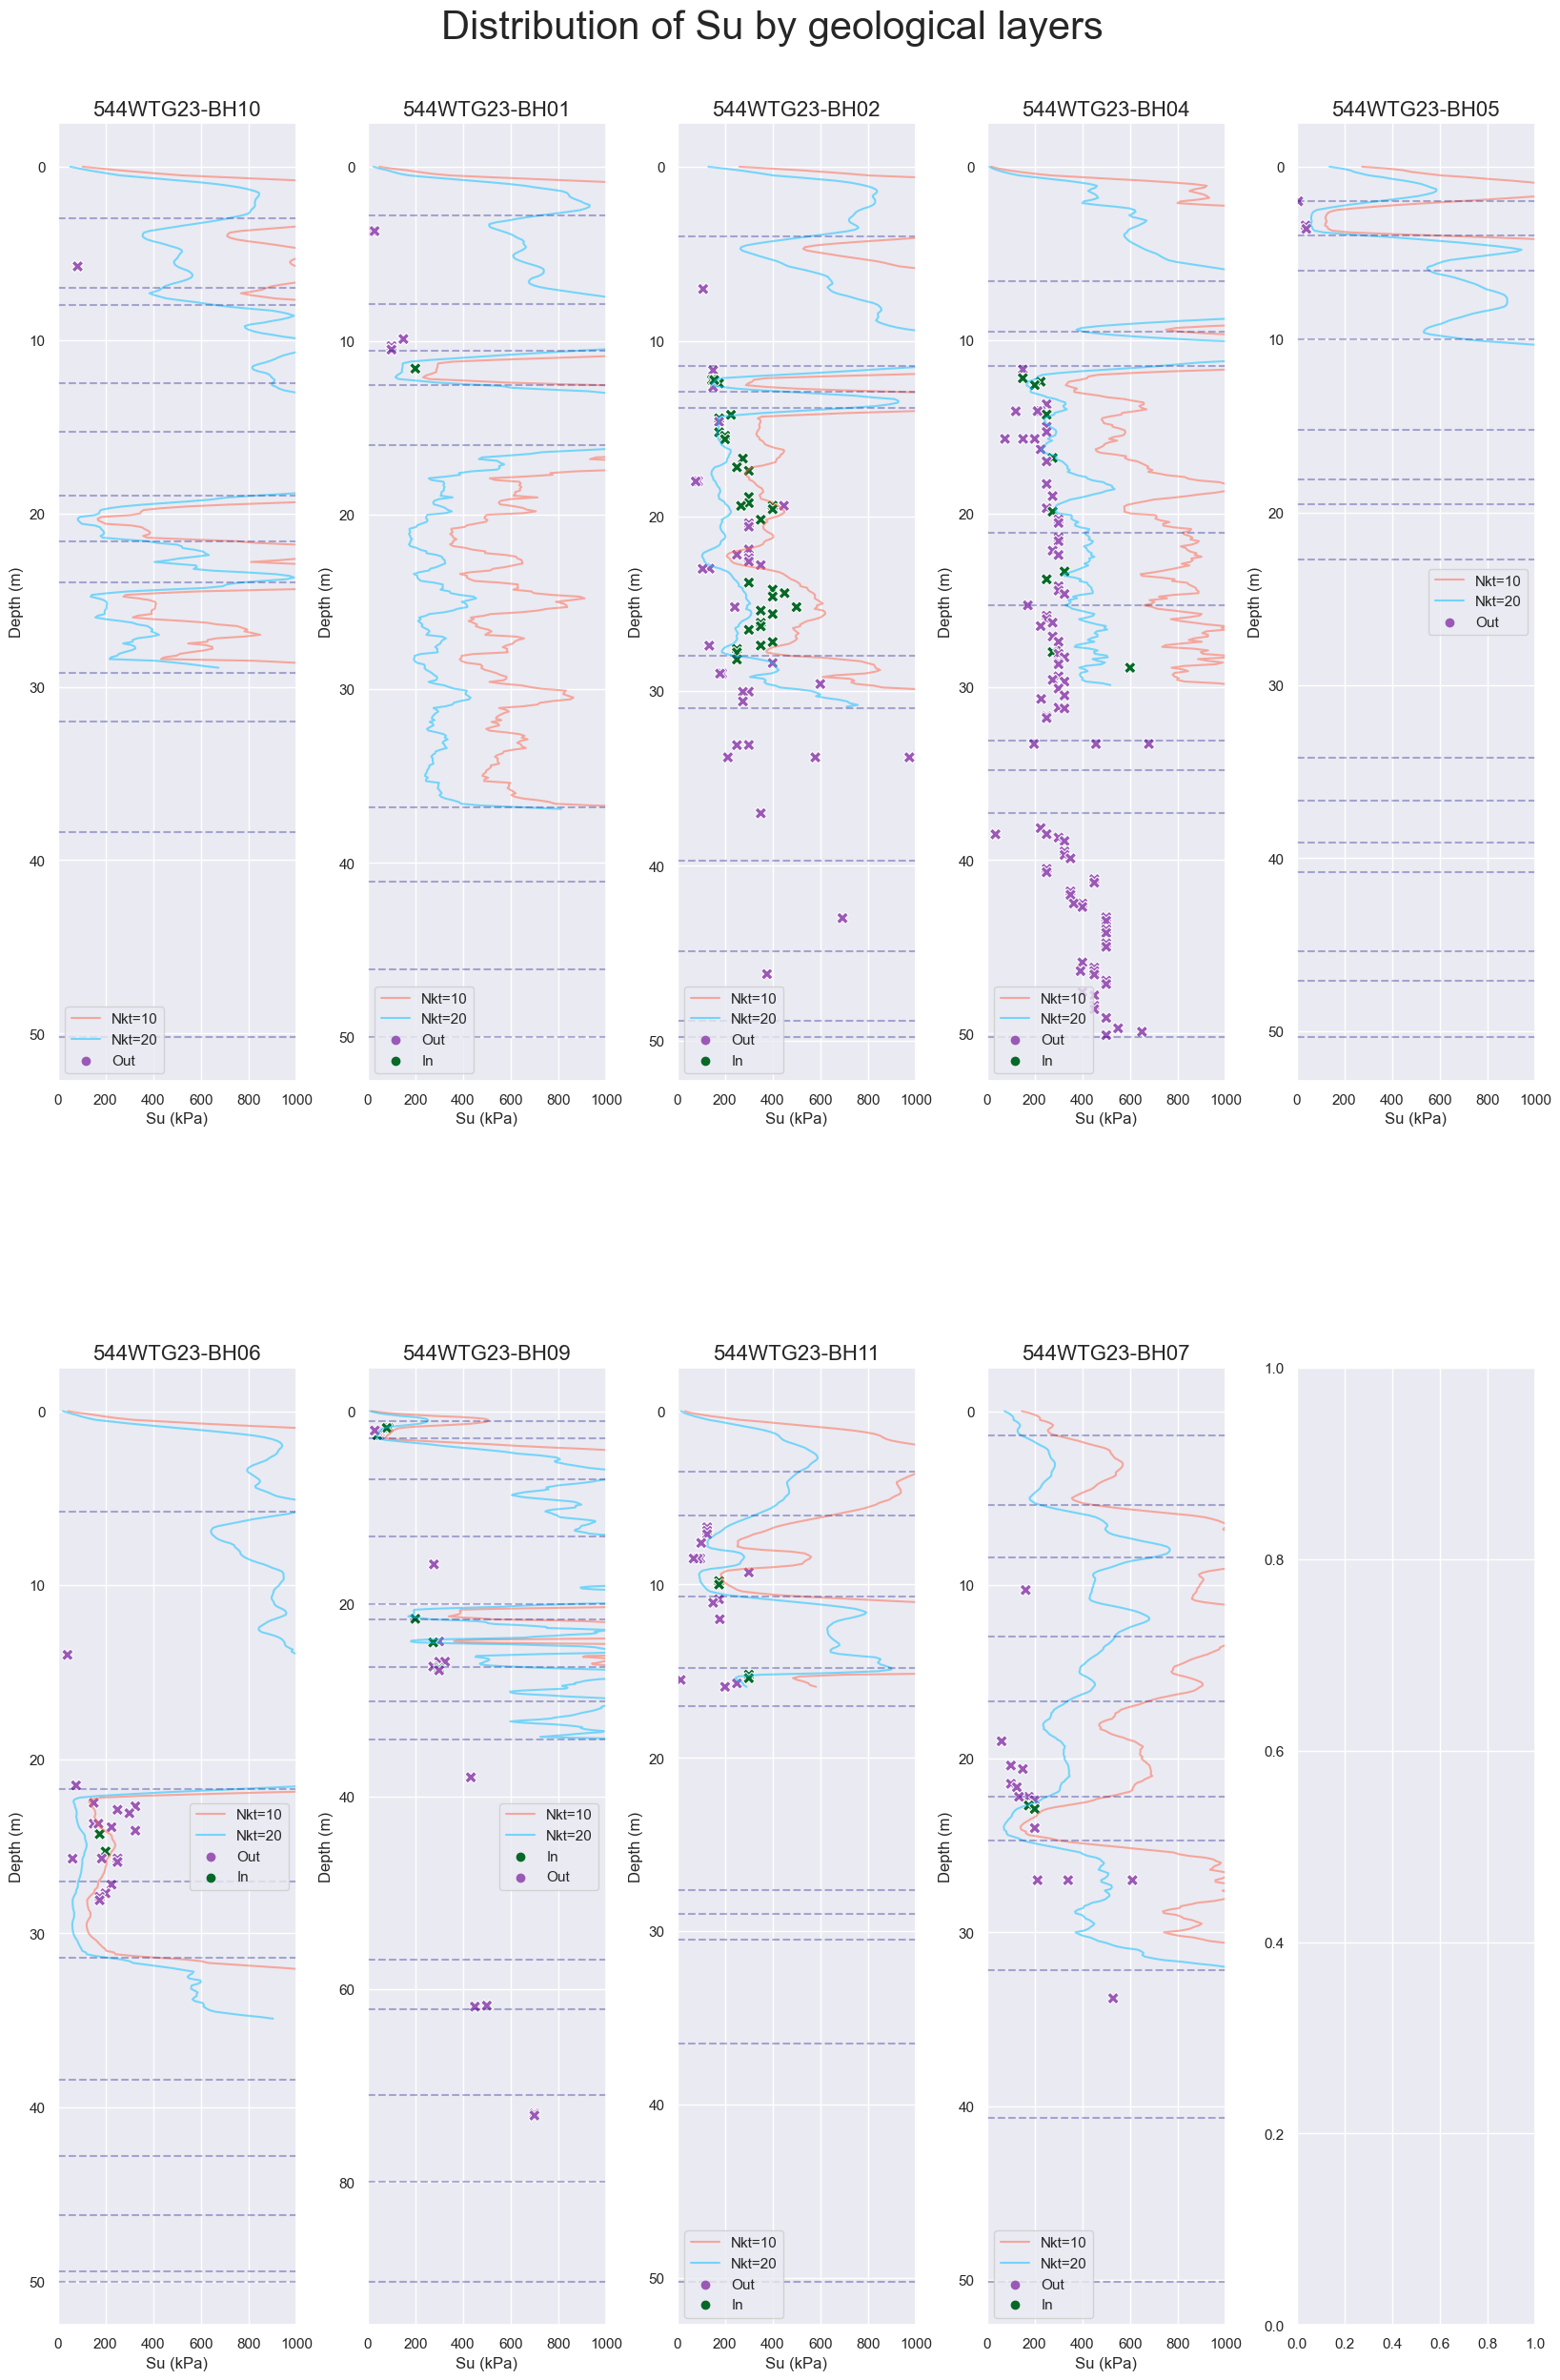

In [23]:
plot_df = su_mean
xmin, xmax = 0, 1000
############################
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(2, 5)
fig.suptitle(f'Distribution of {parameter} by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 30)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.lineplot(data=filtered_df, x="Su (Nkt 10)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="tomato", orient="y", label="Nkt=10")
            ax = sns.lineplot(data=filtered_df, x="Su (Nkt 20)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="deepskyblue", orient="y", label="Nkt=20")
            ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Nkt check", marker="X", alpha=1, ax=axes[row, col], s=80,
                                palette=dict(Out="#9b59b6", In="#076928", Mid="#f20000"))
            # Plot geology
            bh_geo = geo_df[geo_df["PointID"] == borehole_list[bh]]
            for z in bh_geo["Depth"].to_list():
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=0.3, color="navy", linestyle='dashed')
            ax.set_title(borehole_list[bh], size=16)
            ax.set_ylabel("Depth (m)")
            ax.set_xlabel("Su (kPa)")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            ax.legend()
            bh += 1

## Nkt statistics

Mean = 14.66
Median = 14.02


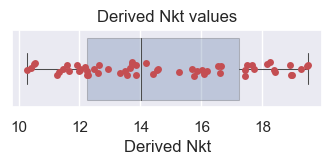

In [26]:
print("Mean =", round(su_df[su_df["Nkt check"] == "In"]["Derived Nkt"].mean(), 2))
print("Median =", round(su_df[su_df["Nkt check"] == "In"]["Derived Nkt"].median(), 2))
under25_df = su_df[su_df["Nkt check"] == "In"]
sns.set(rc={"figure.figsize":(4, 1)})
sns.stripplot(data=under25_df, x="Derived Nkt", c="r")
sns.boxplot(data=under25_df, x="Derived Nkt", boxprops=dict(alpha=.3), linewidth=.75, showfliers= False).set_title("Derived Nkt values")
# Seet value
derived_Nkt = su_df[su_df["Nkt check"] == "In"]["Derived Nkt"].mean()
cpt_df["Su (Nkt derived)"] =  (cpt_df["qnet (kPa)"] - cpt_df["σv (kPa)"]) / derived_Nkt

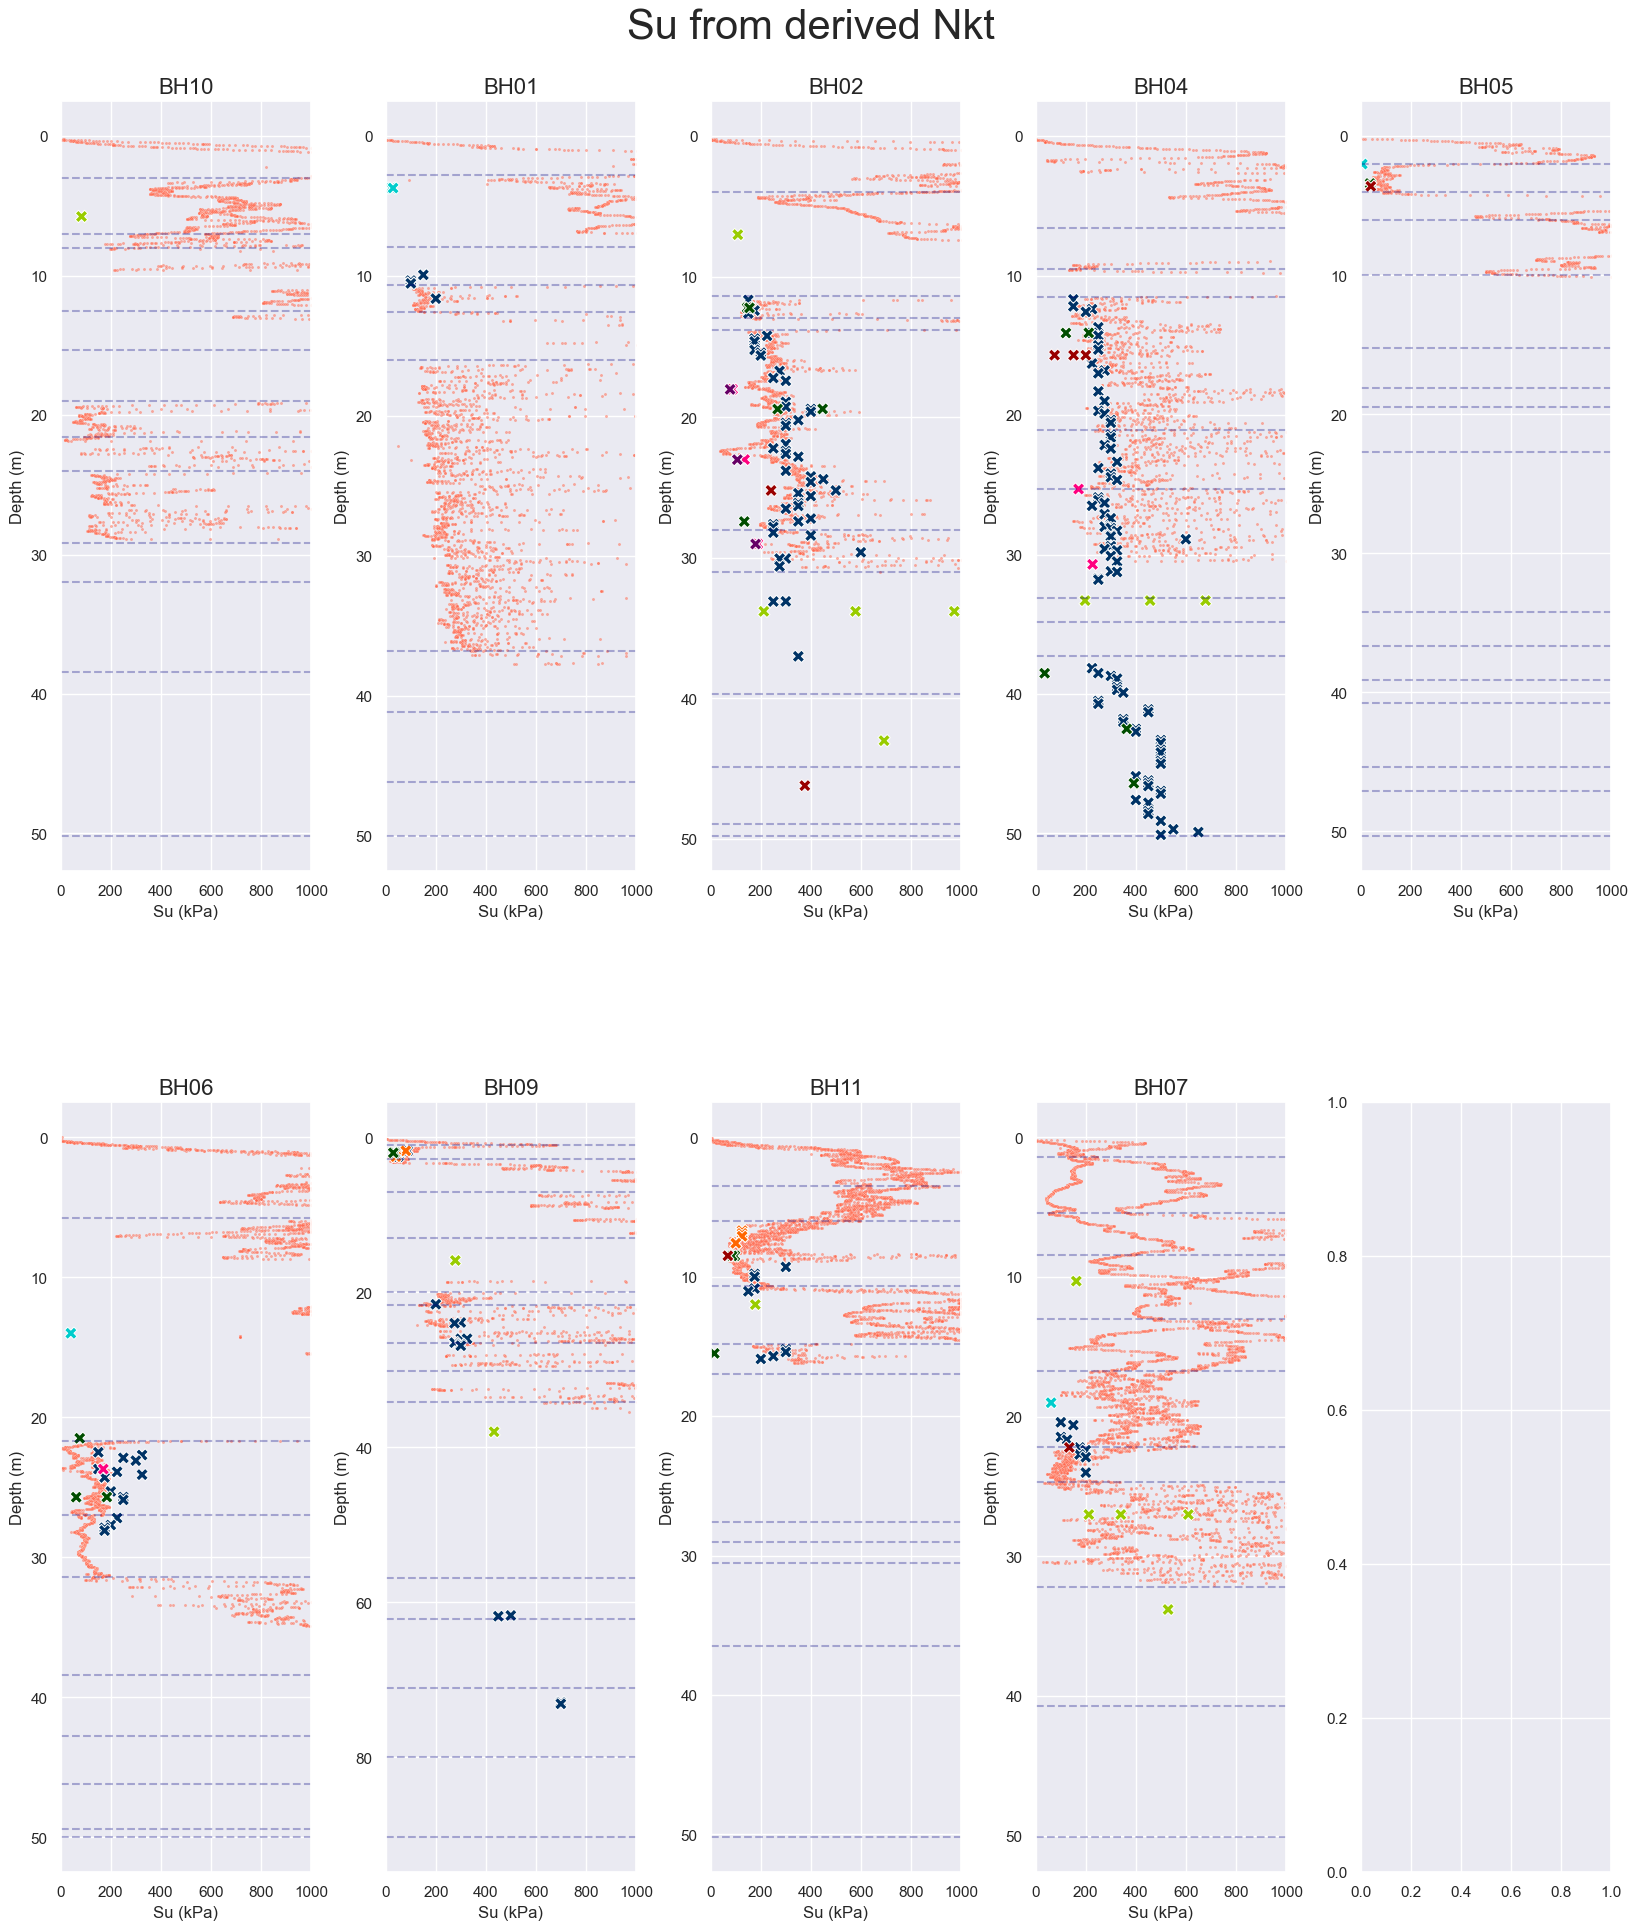

In [42]:
plot_df = cpt_df
xmin, xmax = 0, 1000
su_test_palette = {'LPEN': "#003366", 'TORV':"#ff6600", 'UU':"#004d00", 'CAUC':"#ff007f", 'CAUE':"#660066",
 'CID':"#99cc00", 'CIU':"#990000", 'DSS':"#00cccc"}
############################
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(2, 5)
fig.suptitle(f"Su from derived Nkt", size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 23)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt derived)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="tomato", s=5)
            ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Test", marker="X", alpha=1, ax=axes[row, col], s=80,
                                palette=su_test_palette, legend=False)
            #ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Nkt check", marker="X", alpha=1, ax=axes[row, col], s=80,
                                #palette=dict(Out="#9b59b6", In="#076928", Mid="#f20000"))
 
            # Plot geology
            bh_geo = geo_df[geo_df["PointID"] == borehole_list[bh]]
            for z in bh_geo["Depth"].to_list():
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=0.3, color="navy", linestyle='dashed')
            ax.set_title(borehole_list[bh][-4:], size=16)
            ax.set_ylabel("Depth (m)")
            ax.set_xlabel("Su (kPa)")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            #ax.legend()
            bh += 1

In [33]:
su_df["Test"].unique()

array(['LPEN', 'TORV', 'UU', 'CAUC', 'CAUE', 'CID', 'CIU', 'DSS'],
      dtype=object)

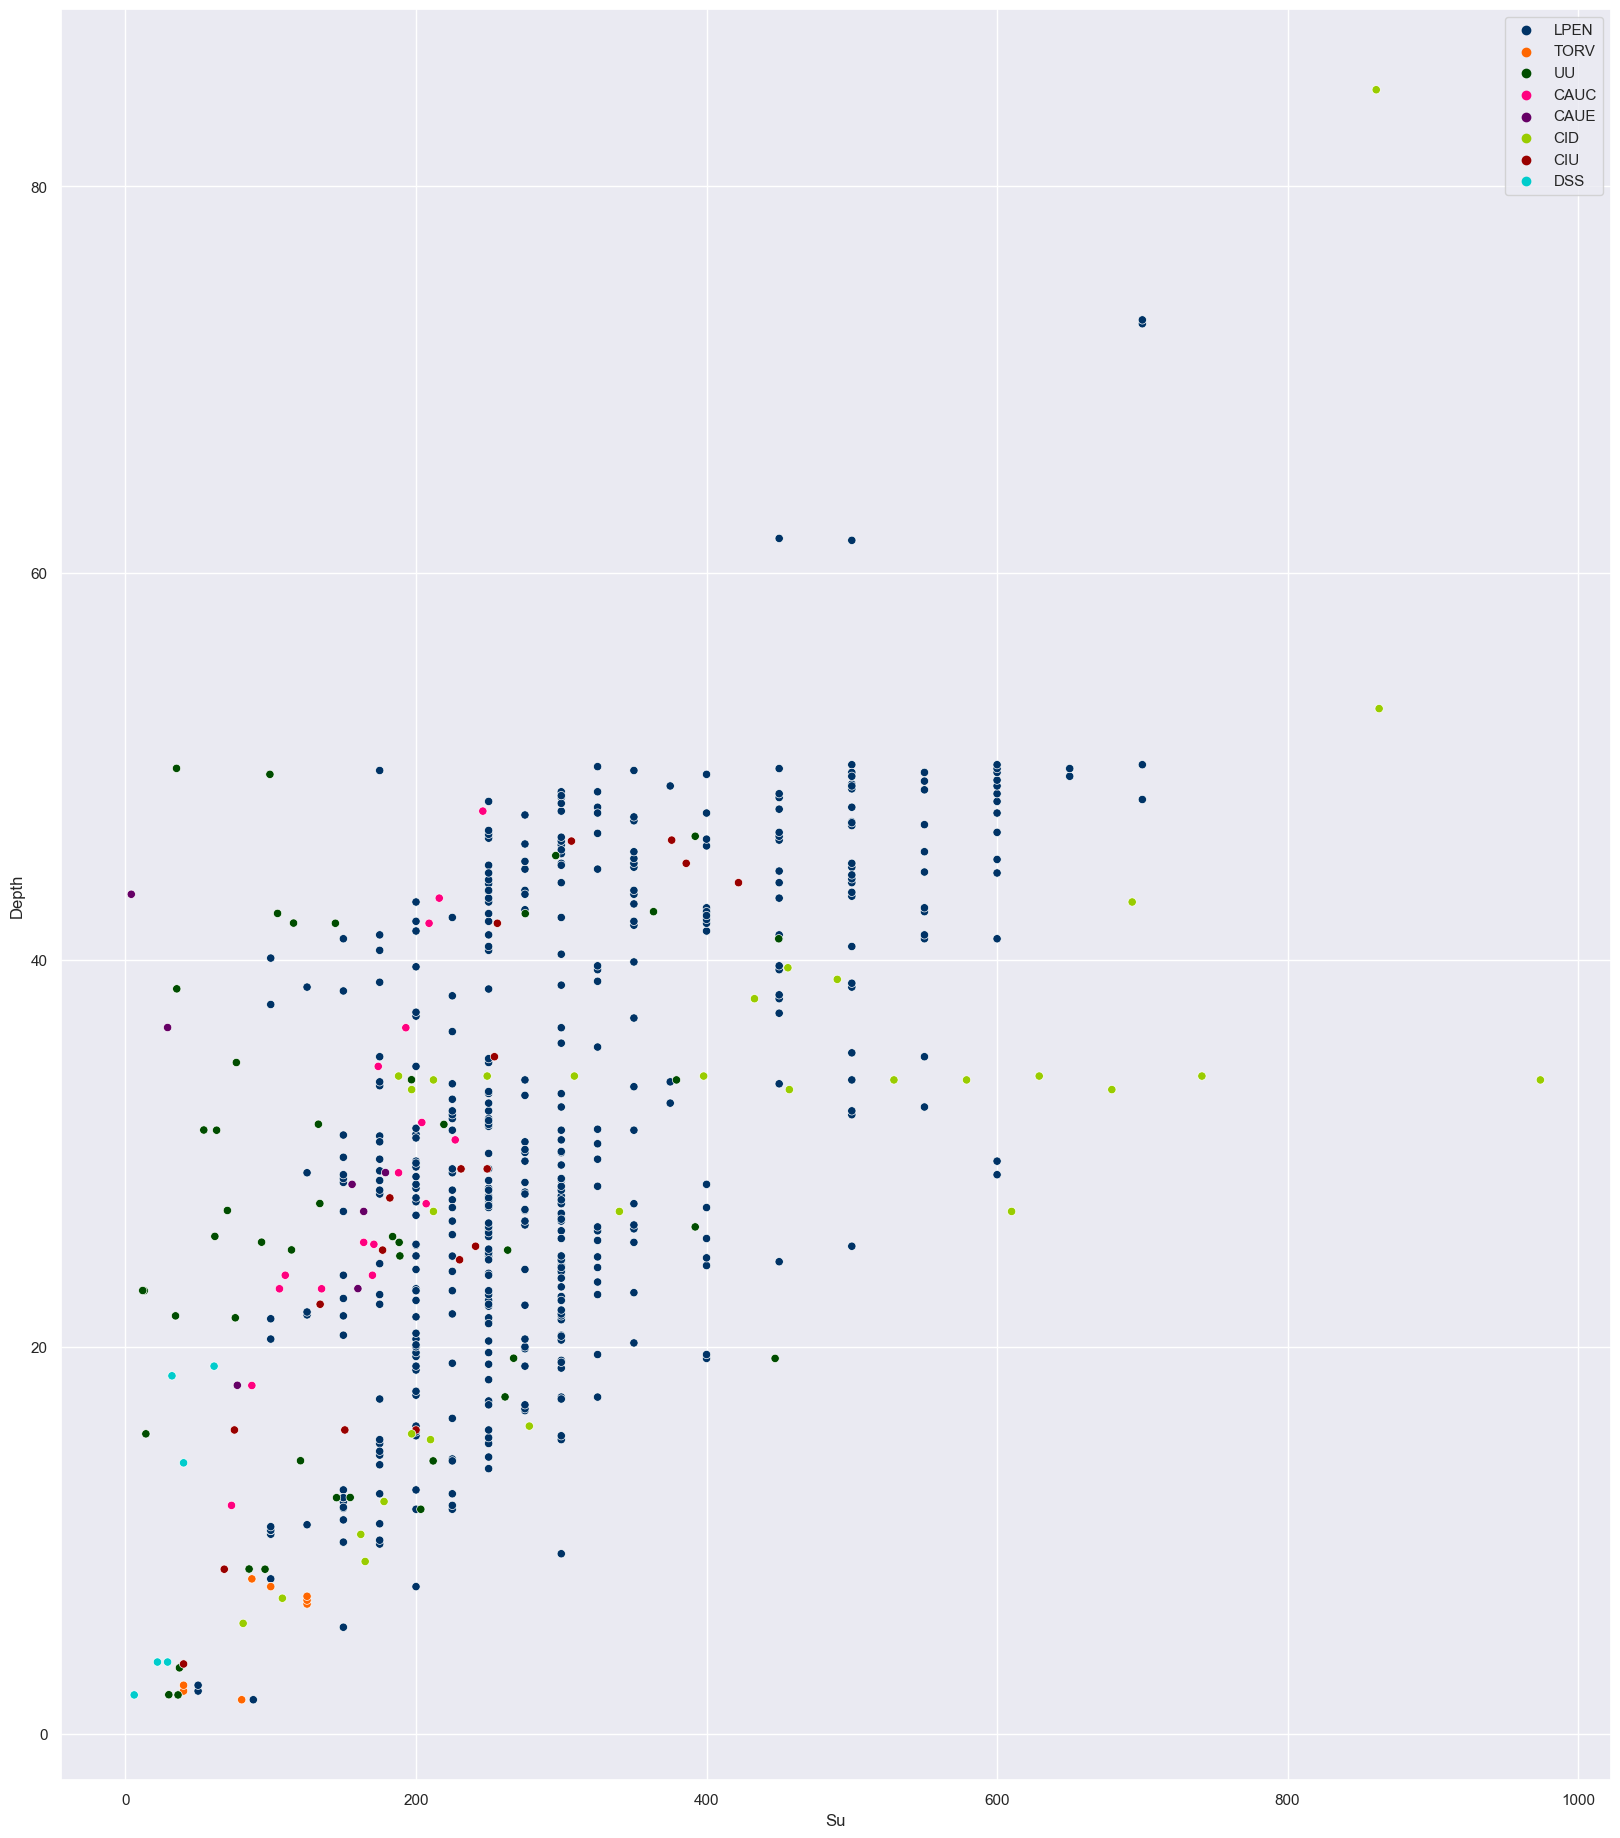

In [41]:
su_test_palette = {'LPEN': "#003366", 'TORV':"#ff6600", 'UU':"#004d00", 'CAUC':"#ff007f", 'CAUE':"#660066",
 'CID':"#99cc00", 'CIU':"#990000", 'DSS':"#00cccc"}
ax = sns.scatterplot(data=su_df, x="Su", y="Depth", hue="Test", palette=su_test_palette)
ax.legend()